<a href="https://colab.research.google.com/github/ychhatre/HistopathologyResearch-/blob/main/HistopathologyResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir /root/.kaggle/
!echo '{"username":"yashchhatre","key":"b7273a42ef02d51280732b44c1d8d582"}' >> /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip -d data/
!rm -rf data/IDC_regular_ps50_idx5 
!rm breast-histopathology-images.zip
!mkdir models
!ls | ls data
!mv data/10299 .

Streaming output truncated to the last 5000 lines.
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1601_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1651_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1701_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1751_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1801_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1851_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1901_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y2301_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2451_y1151_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2451_y1201_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2451_y1251_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/

In [ ]:
import pandas as pd
import os
from skimage import io
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing
import random
from google.colab import drive
import cv2


# pytorch imports 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-78c6680c-cd2d-9576-fd2c-049a5d8b472c)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!ls -1 data/test/0 | wc -l
!ls -1 data/test/1 | wc -l

ls: cannot access 'data/test/0': No such file or directory
0
ls: cannot access 'data/test/1': No such file or directory
0


In [ ]:
#preprocessing data 
root_dir = "data/"

data = []
for folder in tqdm(os.listdir(root_dir)):
  for filename in os.listdir(root_dir + str(folder) + "/0"): 
    
    img = io.imread(root_dir + str(folder) + "/0/" + filename)
    x_cor = filename.split("_")[2][1:]
    y_cor = filename.split("_")[3][1:]

    if(np.array_equal(img.shape, np.array([50,50,3]))): 
      data.append({ 
          "ID": int(folder),
          "cancer": 0, 
          "path": root_dir + str(folder) + "/0/" + filename,
          "x_cor": int(x_cor),
          "y_cor": int(y_cor)
      })
  for filename in os.listdir(root_dir + str(folder) + "/1"): 
    img = io.imread(root_dir + str(folder) + "/1/" + filename)
    x_cor = filename.split("_")[2][1:]
    y_cor = filename.split("_")[3][1:]
    
    if(np.array_equal(img.shape, np.array([50,50,3]))): 
      data.append({ 
          "ID": int(folder),
          "cancer": 1, 
          "path": root_dir + str(folder) + "/1/" + filename,
          "x_cor": int(x_cor),
          "y_cor": int(y_cor)
      })

#generate labels 
df = pd.DataFrame(data)
df.to_csv("data/labels.csv")

print(df.shape)

100%|██████████| 278/278 [01:50<00:00,  2.51it/s]


(273120, 5)


In [ ]:
!ls data

10253  10291  12820  12892  12951  13666  14212  16167	8951  9124  9266
10254  10292  12821  12893  12954  13687  14213  16531	8955  9125  9267
10255  10293  12822  12894  12955  13688  14304  16532	8956  9126  9290
10256  10295  12823  12895  13018  13689  14305  16533	8957  9135  9291
10257  10300  12824  12896  13019  13691  14306  16534	8959  9173  9319
10258  10301  12826  12897  13020  13692  14321  16550	8974  9174  9320
10259  10302  12867  12898  13021  13693  15471  16551	8975  9175  9321
10260  10303  12868  12900  13022  13694  15472  16552	8980  9176  9322
10261  10304  12869  12901  13023  13916  15473  16553	8984  9177  9323
10262  10305  12870  12905  13024  14078  15510  16554	9022  9178  9324
10264  10306  12871  12906  13025  14079  15512  16555	9023  9181  9325
10268  10307  12872  12907  13106  14081  15513  16568	9029  9225  9344
10269  10308  12873  12908  13400  14082  15514  16569	9035  9226  9345
10272  12241  12875  12909  13401  14153  15515  16570	9036  922

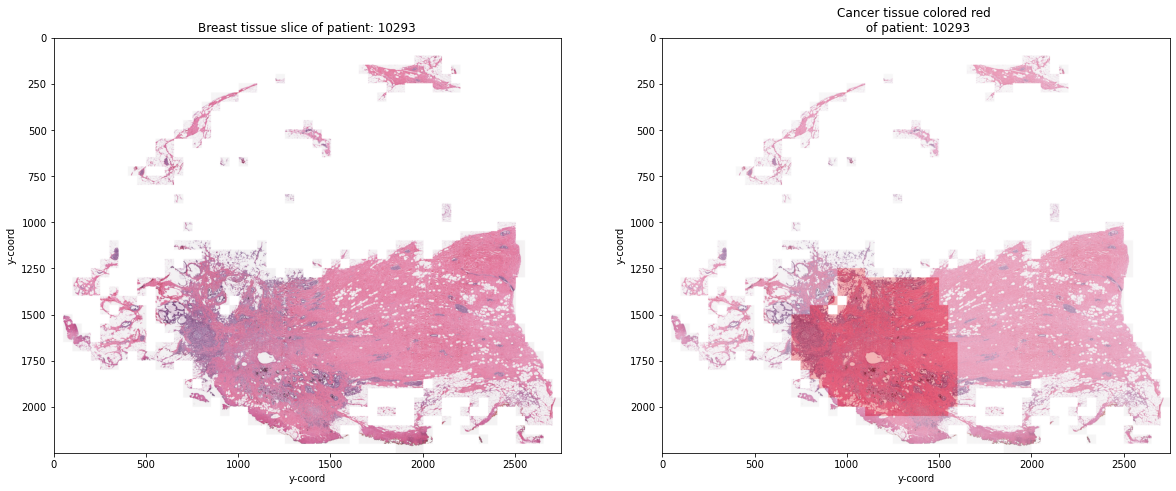

In [ ]:
def visualise_breast_tissue(patient_id, df_param, pred_df=None):
    patient_df = df_param.loc[df_param["ID"] == patient_id]
    max_point = [patient_df["y_cor"].max()-1, patient_df["x_cor"].max()-1]

    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)

    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(patient_df)):
        try:
            image = io.imread(patient_df["path"].values[n])
            
            target = patient_df["cancer"].values[n]
            
            x_coord = int(patient_df["x_cor"].values[n])
            y_coord = int(patient_df["y_cor"].values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0

        except ValueError:
            broken_patches.append(patient_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba
    

example = 10293
grid, mask, broken_patches, _ = visualise_breast_tissue(patient_id=example, df_param=df)
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + str(example))
ax[1].set_title("Cancer tissue colored red \n of patient: " + str(example));

In [ ]:
class BreastCancerIDC(Dataset): 
  def __init__(self, csv_file, transform=None):
    self.observations = pd.read_csv(csv_file) 
    self.transform = transform
  def __len__(self): 
    return len(self.observations)
  def __getitem__(self, idx): 
    img_path = self.observations.iloc[idx, 3]
    img = io.imread(img_path)
    label = torch.tensor(self.observations.iloc[idx, 2])
    patient_id = self.observations.iloc[idx,1]
    if self.transform:
      img = self.transform(img)
    return img, label
    

In [ ]:
class ConvNetwork(nn.Module): 
  def __init__(self, name): 
    super(ConvNetwork, self).__init__()
    self.name = name

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=4)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(256)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout = nn.Dropout(0.50)
    self.fc1 = nn.Linear(256, 1)
        
  def forward(self, x):
    #[batchsize, 3, 50, 50]
    x = self.pool(F.relu(self.bn1(self.conv1(x)))) #[batch, 32, 28, 28]
    x = self.dropout(x)
    x = self.pool(F.relu(self.bn2(self.conv2(x)))) #[batch, 64, 12, 12]
    x = self.dropout(x)
    x = self.pool(F.relu(self.bn3(self.conv3(x)))) #[batch, 128, 4, 4]
    x = self.dropout(x)
    x = self.pool(F.relu(self.bn4(self.conv4(x)))) #[batch, 256, 1, 1]
    x = x.view(-1, 256)
    x = self.dropout(x)
    x = self.fc1(x)
    
    x = torch.flatten(x)

    return x


In [ ]:
class EarlyStopping(): 
  def __init__(self, min_delta, min_delta2, tolerance, patience): 
    self.tolerance = tolerance
    self.patience = patience 
    self.min_delta = min_delta
    self.min_delta2 = min_delta2
    self.counter = 0 
    self.counter2 = 0
    self.early_stop = False

  def __call__(self, train_loss, val_loss, val_latest, val_prev): 
    if(val_loss - train_loss > self.min_delta): 
      self.counter += 1
      if self.counter >= self.tolerance: 
        self.early_stop = True
    else: 
      self.counter = 0
    
    if(abs(val_latest - val_prev) < 0.001): 
      self.counter2 += 1
      if(self.counter2 >= self.patience): 
        self.early_stop = True
      else: 
        self.counter2 = 0

class Trainer():
  def __init__(self, model, loss_function, optimizer, num_epochs, train_loader, val_loader, test_loader) -> None:
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer 
    self.num_epochs = num_epochs 
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.test_loader = test_loader
  
  def plot_loss(self, train_loss, val_loss, train_acc, val_acc): 
    fig, axs = plt.subplots(2, 2, figsize=(10,10))

    axs[0,0].plot(train_loss)
    axs[0,0].set_title("Training Loss")

    axs[0,1].plot(train_acc)
    axs[0,1].set_title("Training Accuracy")

    axs[1,0].plot(val_loss)
    axs[1,0].set_title("Validation Loss")

    axs[1,1].plot(val_acc)
    axs[1,1].set_title("Validation Accuracy")

    fig.suptitle(self.model.name)

    plt.show()  


  def train(self): # runs one epoch of training 
    losses = []
    correct = 0
    samples = 0
    for batch_idx, (data, targets) in enumerate(self.train_loader): 
      #get predictions 
      scores = self.model(data.to(device).float())

      #compute loss
      loss = self.loss_function(scores.to(device).float(), targets.to(device).float())

      #do optimization 
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      #classify predictions
      predictions = (scores > 0.5)
      
      #sum correct & find total samples
      correct += (predictions == targets.to(device).float()).sum()
      samples += scores.size(0)

      # append losses & average
      losses.append(loss.item())
    return np.mean(losses), float(correct / samples)
      

  def validation(self): 
    val_loss = []
    correct = 0
    samples = 0

    self.model.eval()
    for batch_idx, (data, targets) in enumerate(self.val_loader): 
      #get predictions 
      scores = self.model(data.to(device).float())

      #classify predictions
      predictions = (scores > 0.5)
      
      #sum correct & find total samples
      correct += (predictions == targets.to(device).float()).sum()
      samples += scores.size(0)
      
      #compute average loss 
      loss = self.loss_function(scores.to(device).float(), targets.to(device).float())
      val_loss.append(loss.item()) 

    return np.mean(val_loss), float(correct / samples)

  def training(self): 
    train_loss = []
    validation_loss = []
    training_acc = []
    validation_acc = []
    early_stopping = EarlyStopping(min_delta=0.05, min_delta2=0.0005, tolerance=8, patience=8)

    for epoch in tqdm(range(self.num_epochs)):
      loss, train_acc = self.train()
      train_loss.append(loss)
      training_acc.append(train_acc)


      val_loss, val_acc = self.validation()
      validation_loss.append(val_loss)
      validation_acc.append(val_acc)

      print(f"epoch is {epoch + 1} and train_loss is {train_loss[epoch]} and val_loss is {validation_loss[epoch]}")
      print(f"epoch is {epoch + 1} and train_acc is {training_acc[epoch]} and val_accuracy is {validation_acc[epoch]}")

      
      early_stopping(loss, val_loss, validation_loss[epoch], validation_loss[epoch-1])

      if early_stopping.early_stop:
        print("We are at epoch:", str(epoch))
        break
    
  
    self.plot_loss(train_loss, validation_loss, training_acc, validation_acc)
    self.displayResults()

    return {"train_loss": train_loss, "val_loss": validation_loss, "train_acc": training_acc, "val_acc": validation_acc}
  
  def check_accuracy(self, loader):
    correct = 0
    samples = 0
    labels = []
    targets = []
    self.model.eval()
    
    with torch.no_grad():
      for x,y in loader: 
        scores = self.model(x.to(device).float())
        predictions = (scores > 0.5)
        targets.append((scores.detach().cpu().numpy()))
        correct += (predictions == y.to(device).float()).sum()
        samples += scores.size(0)
        labels.append(y.detach().numpy())

      print(f'{correct}/{samples}')
    labels = [int(item) for sublist in labels for item in sublist]
    targets = [int(item) for sublist in targets for item in sublist]
    return labels, targets
  
  def dataAnalysisResults(self, labels, predictions, isTraining): 
    cfm = ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize="all")  
    
    for i in range(len(predictions)): 
      predictions = (predictions[i] > 0.5)
    roc = RocCurveDisplay.from_predictions(labels, predictions)

    cfm.ax_.set_title("Training: " + str(self.model.name) if isTraining else "Test: " + str(self.model.name))
    roc.ax_.set_title("Training: " + str(self.model.name) if isTraining else "Test: " + str(self.model.name))

  def displayResults(self): 
    print("Training set: ")
    train_labels, train_preds = self.check_accuracy(self.train_loader)
    self.dataAnalysisResults(train_labels, train_preds, True)

    print("Test set: ")
    test_labels, test_predictions = self.check_accuracy(self.test_loader)
    self.dataAnalysisResults(test_labels, test_predictions, False)


In [ ]:
dataset = BreastCancerIDC(csv_file="data/labels.csv", transform=transforms.Compose([
   transforms.ToTensor(), 
   transforms.Normalize((0.7183, 0.5589, 0.6473), (0.2765, 0.2514, 0.2582)),
   transforms.RandomRotation(degrees=90),
   transforms.RandomHorizontalFlip(),
   transforms.RandomVerticalFlip(),
]))

models = [
    # {"batch_size": 256, "learning_rate": 1e-3, "model": ConvNetwork("1e-3_256_1e-5").to(device), "weight_decay": 1e-5}, 
    # {"batch_size": 512, "learning_rate": 1e-3, "model": ConvNetwork("1e-3_512_1e-5").to(device), "weight_decay": 1e-5}, 
    # {"batch_size": 1024, "learning_rate": 1e-3, "model": ConvNetwork("1e-3_1024_1e-5").to(device), "weight_decay": 1e-5}, 
    # {"batch_size": 2048, "learning_rate": 1e-3, "model": ConvNetwork("1e-3_2048_1e-5").to(device), "weight_decay": 1e-5}, 
    
    {"batch_size": 512, "learning_rate": 1e-3, "model": ConvNetwork("1e-3_512_1e-5").to(device), "weight_decay": 1e-5}, 
    # {"batch_size": 512, "learning_rate": 1e-3, "model": ConvNetwork("1e-3_512_1e-4").to(device), "weight_decay": 1e-4}, 
    # {"batch_size": 512, "learning_rate": 1e-3, "model": ConvNetwork("1e-3_512_1e-3").to(device), "weight_decay": 1e-3}, 
    # {"batch_size": 512, "learning_rate": 1e-3, "model": ConvNetwork("1e-_512_1e-2").to(device), "weight_decay": 1e-2}, 
]

train_set, val_set, test_set, = torch.utils.data.random_split(dataset, [125000, 75000, 73120]) 


In [ ]:
!ls

10299  data  drive  models  sample_data


  1%|          | 1/100 [01:16<2:05:57, 76.34s/it]

epoch is 1 and train_loss is 0.3815080585528393 and val_loss is 0.48355746431415586
epoch is 1 and train_acc is 0.8298479914665222 and val_accuracy is 0.8443066477775574


  2%|▏         | 2/100 [02:25<1:57:25, 71.89s/it]

epoch is 2 and train_loss is 0.34136745625612686 and val_loss is 0.3256776833615335
epoch is 2 and train_acc is 0.8487359881401062 and val_accuracy is 0.8585333228111267


  3%|▎         | 3/100 [03:32<1:53:10, 70.01s/it]

epoch is 3 and train_loss is 0.32416657130328974 and val_loss is 0.320168408406835
epoch is 3 and train_acc is 0.8575760126113892 and val_accuracy is 0.8485333323478699


  4%|▍         | 4/100 [04:41<1:51:02, 69.40s/it]

epoch is 4 and train_loss is 0.3144798182711309 and val_loss is 0.3119140891801743
epoch is 4 and train_acc is 0.8608719706535339 and val_accuracy is 0.8646266460418701


  5%|▌         | 5/100 [05:50<1:49:41, 69.27s/it]

epoch is 5 and train_loss is 0.3113591557254597 and val_loss is 0.30225679318921095
epoch is 5 and train_acc is 0.863968014717102 and val_accuracy is 0.8635466694831848


  6%|▌         | 6/100 [06:59<1:48:19, 69.14s/it]

epoch is 6 and train_loss is 0.30578309924018626 and val_loss is 0.3042531961283716
epoch is 6 and train_acc is 0.8659279942512512 and val_accuracy is 0.8689333200454712


  7%|▋         | 7/100 [08:07<1:46:52, 68.95s/it]

epoch is 7 and train_loss is 0.2981559271715125 and val_loss is 0.3273111723718189
epoch is 7 and train_acc is 0.8696159720420837 and val_accuracy is 0.8720799684524536


  8%|▊         | 8/100 [09:16<1:45:24, 68.74s/it]

epoch is 8 and train_loss is 0.2968953433085461 and val_loss is 0.2954179254316148
epoch is 8 and train_acc is 0.8700559735298157 and val_accuracy is 0.8736933469772339


  9%|▉         | 9/100 [10:25<1:44:22, 68.82s/it]

epoch is 9 and train_loss is 0.2941138945063766 and val_loss is 0.2949394290747286
epoch is 9 and train_acc is 0.8710319995880127 and val_accuracy is 0.8680933117866516


 10%|█         | 10/100 [11:33<1:43:05, 68.73s/it]

epoch is 10 and train_loss is 0.28715850120904496 and val_loss is 0.3044463438647134
epoch is 10 and train_acc is 0.8744239807128906 and val_accuracy is 0.8560799956321716


 11%|█         | 11/100 [12:42<1:41:49, 68.65s/it]

epoch is 11 and train_loss is 0.2859488689169592 and val_loss is 0.2892999361161472
epoch is 11 and train_acc is 0.8754799962043762 and val_accuracy is 0.8702666759490967


 12%|█▏        | 12/100 [13:51<1:40:53, 68.79s/it]

epoch is 12 and train_loss is 0.28205128366849863 and val_loss is 0.29068875616910506
epoch is 12 and train_acc is 0.8768799901008606 and val_accuracy is 0.8809733390808105


 13%|█▎        | 13/100 [14:59<1:39:36, 68.69s/it]

epoch is 13 and train_loss is 0.28033401114600043 and val_loss is 0.2894703491407187
epoch is 13 and train_acc is 0.8776159882545471 and val_accuracy is 0.8629066348075867


 14%|█▍        | 14/100 [16:08<1:38:30, 68.72s/it]

epoch is 14 and train_loss is 0.27925965944114994 and val_loss is 0.2814546840734222
epoch is 14 and train_acc is 0.8775039911270142 and val_accuracy is 0.8829866647720337


 15%|█▌        | 15/100 [17:17<1:37:23, 68.75s/it]

epoch is 15 and train_loss is 0.2748346371918308 and val_loss is 0.29692735497643347
epoch is 15 and train_acc is 0.8790959715843201 and val_accuracy is 0.8827333450317383


 16%|█▌        | 16/100 [18:26<1:36:24, 68.86s/it]

epoch is 16 and train_loss is 0.27473830422576595 and val_loss is 0.2778902940806888
epoch is 16 and train_acc is 0.8803759813308716 and val_accuracy is 0.8787333369255066


 17%|█▋        | 17/100 [19:35<1:35:12, 68.82s/it]

epoch is 17 and train_loss is 0.2702785797265111 and val_loss is 0.2817484827674165
epoch is 17 and train_acc is 0.8826159834861755 and val_accuracy is 0.8817200064659119


 18%|█▊        | 18/100 [20:44<1:34:15, 68.97s/it]

epoch is 18 and train_loss is 0.2696140715662314 and val_loss is 0.2703475582153619
epoch is 18 and train_acc is 0.8818479776382446 and val_accuracy is 0.8794933557510376


 19%|█▉        | 19/100 [21:53<1:33:11, 69.04s/it]

epoch is 19 and train_loss is 0.26768327300645867 and val_loss is 0.2832510679149303
epoch is 19 and train_acc is 0.8826079964637756 and val_accuracy is 0.8752399682998657


 20%|██        | 20/100 [23:02<1:31:49, 68.86s/it]

epoch is 20 and train_loss is 0.26642008320409427 and val_loss is 0.27702411725407555
epoch is 20 and train_acc is 0.8831279873847961 and val_accuracy is 0.8871999979019165


 21%|██        | 21/100 [24:11<1:30:53, 69.03s/it]

epoch is 21 and train_loss is 0.2641550228303792 and val_loss is 0.2742393568259518
epoch is 21 and train_acc is 0.8851919770240784 and val_accuracy is 0.8733333349227905


 22%|██▏       | 22/100 [25:20<1:29:49, 69.09s/it]

epoch is 22 and train_loss is 0.26339621531720064 and val_loss is 0.26969031300269014
epoch is 22 and train_acc is 0.8853840231895447 and val_accuracy is 0.8854799866676331


 23%|██▎       | 23/100 [26:30<1:28:50, 69.22s/it]

epoch is 23 and train_loss is 0.26087648485388076 and val_loss is 0.288334006963133
epoch is 23 and train_acc is 0.886784017086029 and val_accuracy is 0.8856533169746399


 24%|██▍       | 24/100 [27:39<1:27:36, 69.16s/it]

epoch is 24 and train_loss is 0.2623235382595841 and val_loss is 0.27060094962314685
epoch is 24 and train_acc is 0.8861759901046753 and val_accuracy is 0.8736799955368042


 25%|██▌       | 25/100 [28:47<1:25:56, 68.75s/it]

epoch is 25 and train_loss is 0.25804803334936804 and val_loss is 0.26206455587529814
epoch is 25 and train_acc is 0.8877040147781372 and val_accuracy is 0.8866666555404663


 26%|██▌       | 26/100 [29:55<1:24:33, 68.56s/it]

epoch is 26 and train_loss is 0.2547162151458312 and val_loss is 0.25884173506376695
epoch is 26 and train_acc is 0.8895679712295532 and val_accuracy is 0.8887466788291931


 27%|██▋       | 27/100 [31:03<1:23:13, 68.41s/it]

epoch is 27 and train_loss is 0.25677333662704543 and val_loss is 0.25927306610305295
epoch is 27 and train_acc is 0.8883600234985352 and val_accuracy is 0.8911200165748596


 28%|██▊       | 28/100 [32:11<1:22:11, 68.50s/it]

epoch is 28 and train_loss is 0.25327674150466917 and val_loss is 0.2639117465943706
epoch is 28 and train_acc is 0.8897039890289307 and val_accuracy is 0.8875600099563599


 29%|██▉       | 29/100 [33:19<1:20:52, 68.35s/it]

epoch is 29 and train_loss is 0.25221535350595203 and val_loss is 0.26211366756838195
epoch is 29 and train_acc is 0.8907279968261719 and val_accuracy is 0.882973313331604


 30%|███       | 30/100 [34:29<1:20:02, 68.61s/it]

epoch is 30 and train_loss is 0.25105108831609996 and val_loss is 0.25666526669547673
epoch is 30 and train_acc is 0.8896880149841309 and val_accuracy is 0.8910800218582153


 31%|███       | 31/100 [35:37<1:18:49, 68.54s/it]

epoch is 31 and train_loss is 0.24879452993675155 and val_loss is 0.28037358354143543
epoch is 31 and train_acc is 0.8916879892349243 and val_accuracy is 0.8782399892807007


 32%|███▏      | 32/100 [36:46<1:17:46, 68.63s/it]

epoch is 32 and train_loss is 0.24813976591947126 and val_loss is 0.26018065680451946
epoch is 32 and train_acc is 0.892911970615387 and val_accuracy is 0.8801999688148499


 33%|███▎      | 33/100 [37:55<1:16:49, 68.79s/it]

epoch is 33 and train_loss is 0.2464024552885367 and val_loss is 0.2540464284671407
epoch is 33 and train_acc is 0.8936479687690735 and val_accuracy is 0.8933733105659485


 34%|███▍      | 34/100 [39:04<1:15:33, 68.68s/it]

epoch is 34 and train_loss is 0.2459960848093033 and val_loss is 0.27012937044610785
epoch is 34 and train_acc is 0.8930000066757202 and val_accuracy is 0.871066689491272


 35%|███▌      | 35/100 [40:13<1:14:30, 68.78s/it]

epoch is 35 and train_loss is 0.24638742725459897 and val_loss is 0.25044067102630124
epoch is 35 and train_acc is 0.8926399946212769 and val_accuracy is 0.8887066841125488


 36%|███▌      | 36/100 [41:21<1:13:16, 68.70s/it]

epoch is 36 and train_loss is 0.24161035248211452 and val_loss is 0.2521474242818599
epoch is 36 and train_acc is 0.896016001701355 and val_accuracy is 0.8921599984169006


 37%|███▋      | 37/100 [42:30<1:12:13, 68.78s/it]

epoch is 37 and train_loss is 0.24213176923138754 and val_loss is 0.27990200253976444
epoch is 37 and train_acc is 0.894320011138916 and val_accuracy is 0.8672933578491211


 38%|███▊      | 38/100 [43:39<1:11:14, 68.95s/it]

epoch is 38 and train_loss is 0.24188713996994252 and val_loss is 0.25055309227940176
epoch is 38 and train_acc is 0.8948879837989807 and val_accuracy is 0.8913466930389404


 39%|███▉      | 39/100 [44:48<1:10:02, 68.90s/it]

epoch is 39 and train_loss is 0.24126580917105384 and val_loss is 0.2535833443711404
epoch is 39 and train_acc is 0.8961679935455322 and val_accuracy is 0.8944000005722046


 40%|████      | 40/100 [45:57<1:08:55, 68.93s/it]

epoch is 40 and train_loss is 0.23993239098665667 and val_loss is 0.2514031783861368
epoch is 40 and train_acc is 0.895904004573822 and val_accuracy is 0.8960933089256287


 41%|████      | 41/100 [47:06<1:07:39, 68.81s/it]

epoch is 41 and train_loss is 0.23746336856666878 and val_loss is 0.24838095366143856
epoch is 41 and train_acc is 0.8964399695396423 and val_accuracy is 0.8920800089836121


 42%|████▏     | 42/100 [48:14<1:06:28, 68.77s/it]

epoch is 42 and train_loss is 0.23632671535015107 and val_loss is 0.2458535782536682
epoch is 42 and train_acc is 0.8980640172958374 and val_accuracy is 0.8948533535003662


 43%|████▎     | 43/100 [49:24<1:05:34, 69.02s/it]

epoch is 43 and train_loss is 0.23759507476067057 and val_loss is 0.24844623554726036
epoch is 43 and train_acc is 0.8970639705657959 and val_accuracy is 0.8914933204650879


 44%|████▍     | 44/100 [50:33<1:04:19, 68.93s/it]

epoch is 44 and train_loss is 0.23446143056665147 and val_loss is 0.24627198876977777
epoch is 44 and train_acc is 0.8989920020103455 and val_accuracy is 0.8912533521652222


 45%|████▌     | 45/100 [51:42<1:03:19, 69.09s/it]

epoch is 45 and train_loss is 0.2341435298019526 and val_loss is 0.24705784448555537
epoch is 45 and train_acc is 0.8986560106277466 and val_accuracy is 0.8940266370773315


 46%|████▌     | 46/100 [52:51<1:02:07, 69.03s/it]

epoch is 46 and train_loss is 0.2331546501237519 and val_loss is 0.24561236291921057
epoch is 46 and train_acc is 0.8993840217590332 and val_accuracy is 0.8987066745758057


 47%|████▋     | 47/100 [54:00<1:01:01, 69.08s/it]

epoch is 47 and train_loss is 0.2332295210385809 and val_loss is 0.25953422760476874
epoch is 47 and train_acc is 0.8991439938545227 and val_accuracy is 0.895026683807373


 48%|████▊     | 48/100 [55:09<59:42, 68.90s/it]  

epoch is 48 and train_loss is 0.23346213321296536 and val_loss is 0.24755835421636802
epoch is 48 and train_acc is 0.8988879919052124 and val_accuracy is 0.8922533392906189


 49%|████▉     | 49/100 [56:18<58:36, 68.96s/it]

epoch is 49 and train_loss is 0.23263652811245042 and val_loss is 0.2488592861055517
epoch is 49 and train_acc is 0.8993279933929443 and val_accuracy is 0.8835999965667725


 50%|█████     | 50/100 [57:27<57:26, 68.93s/it]

epoch is 50 and train_loss is 0.22882870216758883 and val_loss is 0.2435472740405271
epoch is 50 and train_acc is 0.9009919762611389 and val_accuracy is 0.8935466408729553


 51%|█████     | 51/100 [58:35<56:10, 68.78s/it]

epoch is 51 and train_loss is 0.23032450694210677 and val_loss is 0.25772518193235205
epoch is 51 and train_acc is 0.8994879722595215 and val_accuracy is 0.887719988822937


 52%|█████▏    | 52/100 [59:44<55:05, 68.85s/it]

epoch is 52 and train_loss is 0.22972207032904332 and val_loss is 0.2432795481211474
epoch is 52 and train_acc is 0.9011920094490051 and val_accuracy is 0.8961466550827026


 53%|█████▎    | 53/100 [1:00:53<53:49, 68.72s/it]

epoch is 53 and train_loss is 0.22722901878308277 and val_loss is 0.24300084430344251
epoch is 53 and train_acc is 0.901095986366272 and val_accuracy is 0.8975066542625427


 54%|█████▍    | 54/100 [1:02:01<52:38, 68.66s/it]

epoch is 54 and train_loss is 0.226988506621244 and val_loss is 0.24127006986919713
epoch is 54 and train_acc is 0.902135968208313 and val_accuracy is 0.8982666730880737


 55%|█████▌    | 55/100 [1:03:10<51:33, 68.74s/it]

epoch is 55 and train_loss is 0.22728849320995564 and val_loss is 0.2400435566091213
epoch is 55 and train_acc is 0.9014559984207153 and val_accuracy is 0.8960133194923401


 56%|█████▌    | 56/100 [1:04:18<50:19, 68.63s/it]

epoch is 56 and train_loss is 0.22755450344815545 and val_loss is 0.24644351025827888
epoch is 56 and train_acc is 0.9012960195541382 and val_accuracy is 0.8936533331871033


 57%|█████▋    | 57/100 [1:05:27<49:11, 68.65s/it]

epoch is 57 and train_loss is 0.22440150811964152 and val_loss is 0.23846041811566773
epoch is 57 and train_acc is 0.9027919769287109 and val_accuracy is 0.8984000086784363


 58%|█████▊    | 58/100 [1:06:35<47:59, 68.55s/it]

epoch is 58 and train_loss is 0.22328779958948797 and val_loss is 0.241619524298882
epoch is 58 and train_acc is 0.9034000039100647 and val_accuracy is 0.889959990978241


 59%|█████▉    | 59/100 [1:07:45<47:00, 68.78s/it]

epoch is 59 and train_loss is 0.22469762399488566 and val_loss is 0.24076469587225494
epoch is 59 and train_acc is 0.9029200077056885 and val_accuracy is 0.8976399898529053


 60%|██████    | 60/100 [1:08:55<46:05, 69.13s/it]

epoch is 60 and train_loss is 0.2243217608150171 and val_loss is 0.2540066959906597
epoch is 60 and train_acc is 0.903768002986908 and val_accuracy is 0.8866666555404663


 61%|██████    | 61/100 [1:10:04<44:58, 69.19s/it]

epoch is 61 and train_loss is 0.2235960863074478 and val_loss is 0.25230288069669893
epoch is 61 and train_acc is 0.9036800265312195 and val_accuracy is 0.8846666812896729


 62%|██████▏   | 62/100 [1:11:14<43:57, 69.41s/it]

epoch is 62 and train_loss is 0.22178860738569375 and val_loss is 0.2405002244881221
epoch is 62 and train_acc is 0.9040799736976624 and val_accuracy is 0.8925466537475586


 63%|██████▎   | 63/100 [1:12:24<42:50, 69.49s/it]

epoch is 63 and train_loss is 0.22204889229365757 and val_loss is 0.23767481125941892
epoch is 63 and train_acc is 0.9039679765701294 and val_accuracy is 0.8968266844749451


 64%|██████▍   | 64/100 [1:13:33<41:41, 69.48s/it]

epoch is 64 and train_loss is 0.2209992779152734 and val_loss is 0.24773409364580298
epoch is 64 and train_acc is 0.9049760103225708 and val_accuracy is 0.8878933191299438


 65%|██████▌   | 65/100 [1:14:43<40:34, 69.56s/it]

epoch is 65 and train_loss is 0.21790744455493227 and val_loss is 0.23866665353174923
epoch is 65 and train_acc is 0.9056079983711243 and val_accuracy is 0.9003999829292297


 66%|██████▌   | 66/100 [1:15:53<39:27, 69.63s/it]

epoch is 66 and train_loss is 0.21885184603078026 and val_loss is 0.24171318022572263
epoch is 66 and train_acc is 0.9056320190429688 and val_accuracy is 0.8951733112335205


 67%|██████▋   | 67/100 [1:17:03<38:25, 69.87s/it]

epoch is 67 and train_loss is 0.21889548447667337 and val_loss is 0.23794894731369148
epoch is 67 and train_acc is 0.9061520099639893 and val_accuracy is 0.8960933089256287


 68%|██████▊   | 68/100 [1:18:12<37:10, 69.70s/it]

epoch is 68 and train_loss is 0.21677523881805186 and val_loss is 0.236890725943507
epoch is 68 and train_acc is 0.906216025352478 and val_accuracy is 0.9014533162117004


 69%|██████▉   | 69/100 [1:19:22<36:03, 69.79s/it]

epoch is 69 and train_loss is 0.21753171816164132 and val_loss is 0.2530877160377243
epoch is 69 and train_acc is 0.9058399796485901 and val_accuracy is 0.9006400108337402


 70%|███████   | 70/100 [1:20:32<34:50, 69.69s/it]

epoch is 70 and train_loss is 0.2166090813218331 and val_loss is 0.25079635941252415
epoch is 70 and train_acc is 0.9067440032958984 and val_accuracy is 0.8901333212852478


 71%|███████   | 71/100 [1:21:41<33:36, 69.52s/it]

epoch is 71 and train_loss is 0.2170050645969352 and val_loss is 0.24218361089829685
epoch is 71 and train_acc is 0.9058480262756348 and val_accuracy is 0.8999999761581421


 72%|███████▏  | 72/100 [1:22:51<32:32, 69.73s/it]

epoch is 72 and train_loss is 0.21734601265313674 and val_loss is 0.24147799631365302
epoch is 72 and train_acc is 0.9065759778022766 and val_accuracy is 0.8952800035476685


 73%|███████▎  | 73/100 [1:24:00<31:19, 69.59s/it]

epoch is 73 and train_loss is 0.21747034788131714 and val_loss is 0.2422527408316022
epoch is 73 and train_acc is 0.9062079787254333 and val_accuracy is 0.9010933041572571


 74%|███████▍  | 74/100 [1:25:11<30:14, 69.79s/it]

epoch is 74 and train_loss is 0.2159222020178425 and val_loss is 0.24176618852177445
epoch is 74 and train_acc is 0.9068880081176758 and val_accuracy is 0.9015066623687744


 75%|███████▌  | 75/100 [1:26:20<29:01, 69.66s/it]

epoch is 75 and train_loss is 0.21445978399442167 and val_loss is 0.2444386038244987
epoch is 75 and train_acc is 0.9078959822654724 and val_accuracy is 0.9039733409881592


 76%|███████▌  | 76/100 [1:27:29<27:49, 69.55s/it]

epoch is 76 and train_loss is 0.21405196013499278 and val_loss is 0.2415725176228958
epoch is 76 and train_acc is 0.9081519842147827 and val_accuracy is 0.8915733098983765


 77%|███████▋  | 77/100 [1:28:39<26:39, 69.56s/it]

epoch is 77 and train_loss is 0.21368162692809592 and val_loss is 0.2448838883314003
epoch is 77 and train_acc is 0.907975971698761 and val_accuracy is 0.9046933054924011


 78%|███████▊  | 78/100 [1:29:48<25:29, 69.51s/it]

epoch is 78 and train_loss is 0.21225214497167236 and val_loss is 0.24915412088640693
epoch is 78 and train_acc is 0.9093279838562012 and val_accuracy is 0.8990399837493896


 79%|███████▉  | 79/100 [1:30:58<24:23, 69.70s/it]

epoch is 79 and train_loss is 0.21430191640951196 and val_loss is 0.23422834601532033
epoch is 79 and train_acc is 0.9080640077590942 and val_accuracy is 0.8984799981117249


 80%|████████  | 80/100 [1:32:08<23:15, 69.77s/it]

epoch is 80 and train_loss is 0.21219233292706158 and val_loss is 0.23914891288799495
epoch is 80 and train_acc is 0.9084479808807373 and val_accuracy is 0.9025733470916748


 81%|████████  | 81/100 [1:33:18<22:04, 69.69s/it]

epoch is 81 and train_loss is 0.21177552701259145 and val_loss is 0.24080367994551755
epoch is 81 and train_acc is 0.9087439775466919 and val_accuracy is 0.9021466374397278


 82%|████████▏ | 82/100 [1:34:28<20:55, 69.74s/it]

epoch is 82 and train_loss is 0.21001024878754906 and val_loss is 0.25089548031489056
epoch is 82 and train_acc is 0.9089840054512024 and val_accuracy is 0.8876799941062927


 83%|████████▎ | 83/100 [1:35:37<19:44, 69.67s/it]

epoch is 83 and train_loss is 0.2096546410297861 and val_loss is 0.24153303664152315
epoch is 83 and train_acc is 0.909600019454956 and val_accuracy is 0.9019200205802917


 84%|████████▍ | 84/100 [1:36:47<18:35, 69.71s/it]

epoch is 84 and train_loss is 0.2105404292746466 and val_loss is 0.23748914603473378
epoch is 84 and train_acc is 0.9088959693908691 and val_accuracy is 0.9026399850845337


 85%|████████▌ | 85/100 [1:37:56<17:23, 69.56s/it]

epoch is 85 and train_loss is 0.21009033863641777 and val_loss is 0.23999668708463914
epoch is 85 and train_acc is 0.909887969493866 and val_accuracy is 0.9032133221626282


 86%|████████▌ | 86/100 [1:39:06<16:15, 69.69s/it]

epoch is 86 and train_loss is 0.20964888595804876 and val_loss is 0.2386059320094634
epoch is 86 and train_acc is 0.9102720022201538 and val_accuracy is 0.9041199684143066


 87%|████████▋ | 87/100 [1:40:15<15:04, 69.54s/it]

epoch is 87 and train_loss is 0.2100800096988678 and val_loss is 0.23873962593727371
epoch is 87 and train_acc is 0.9092879891395569 and val_accuracy is 0.8938400149345398


 88%|████████▊ | 88/100 [1:41:25<13:53, 69.46s/it]

epoch is 88 and train_loss is 0.20735793648933878 and val_loss is 0.23503301794431647
epoch is 88 and train_acc is 0.9099439978599548 and val_accuracy is 0.8992133140563965


 89%|████████▉ | 89/100 [1:42:35<12:45, 69.63s/it]

epoch is 89 and train_loss is 0.20710460671356745 and val_loss is 0.2344799303278631
epoch is 89 and train_acc is 0.91075199842453 and val_accuracy is 0.9024933576583862


 90%|█████████ | 90/100 [1:43:44<11:36, 69.62s/it]

epoch is 90 and train_loss is 0.20739998750540675 and val_loss is 0.23694693302216174
epoch is 90 and train_acc is 0.9110879898071289 and val_accuracy is 0.900493323802948


 91%|█████████ | 91/100 [1:44:54<10:27, 69.74s/it]

epoch is 91 and train_loss is 0.20658918771208548 and val_loss is 0.24078042541636901
epoch is 91 and train_acc is 0.9109920263290405 and val_accuracy is 0.8989466428756714


 92%|█████████▏| 92/100 [1:46:04<09:17, 69.64s/it]

epoch is 92 and train_loss is 0.205968362275435 and val_loss is 0.24043542166956428
epoch is 92 and train_acc is 0.9114559888839722 and val_accuracy is 0.9004533290863037


 93%|█████████▎| 93/100 [1:47:13<08:07, 69.60s/it]

epoch is 93 and train_loss is 0.20665007829666138 and val_loss is 0.24002823355246564
epoch is 93 and train_acc is 0.9113919734954834 and val_accuracy is 0.9023866653442383


 94%|█████████▍| 94/100 [1:48:23<06:58, 69.78s/it]

epoch is 94 and train_loss is 0.20744872166185963 and val_loss is 0.23592362831644462
epoch is 94 and train_acc is 0.9103119969367981 and val_accuracy is 0.8991199731826782


 95%|█████████▌| 95/100 [1:49:33<05:48, 69.66s/it]

epoch is 95 and train_loss is 0.20527977347373963 and val_loss is 0.2417267539671489
epoch is 95 and train_acc is 0.9113439917564392 and val_accuracy is 0.8934000134468079


 96%|█████████▌| 96/100 [1:50:43<04:39, 69.84s/it]

epoch is 96 and train_loss is 0.20384560221311998 and val_loss is 0.24428315815471469
epoch is 96 and train_acc is 0.9127600193023682 and val_accuracy is 0.9034799933433533


 97%|█████████▋| 97/100 [1:51:53<03:29, 69.76s/it]

epoch is 97 and train_loss is 0.20340834156591064 and val_loss is 0.23807825624537307
epoch is 97 and train_acc is 0.9132239818572998 and val_accuracy is 0.9001866579055786


 98%|█████████▊| 98/100 [1:53:02<02:19, 69.68s/it]

epoch is 98 and train_loss is 0.20375929207217935 and val_loss is 0.23116299641781113
epoch is 98 and train_acc is 0.9122959971427917 and val_accuracy is 0.9031199812889099


 99%|█████████▉| 99/100 [1:54:12<01:09, 69.73s/it]

epoch is 99 and train_loss is 0.20423298313909646 and val_loss is 0.23123102204329302
epoch is 99 and train_acc is 0.9124079942703247 and val_accuracy is 0.8998666405677795


100%|██████████| 100/100 [1:55:22<00:00, 69.22s/it]

epoch is 100 and train_loss is 0.20382389730336714 and val_loss is 0.2356498123837166
epoch is 100 and train_acc is 0.9118319749832153 and val_accuracy is 0.901973307132721


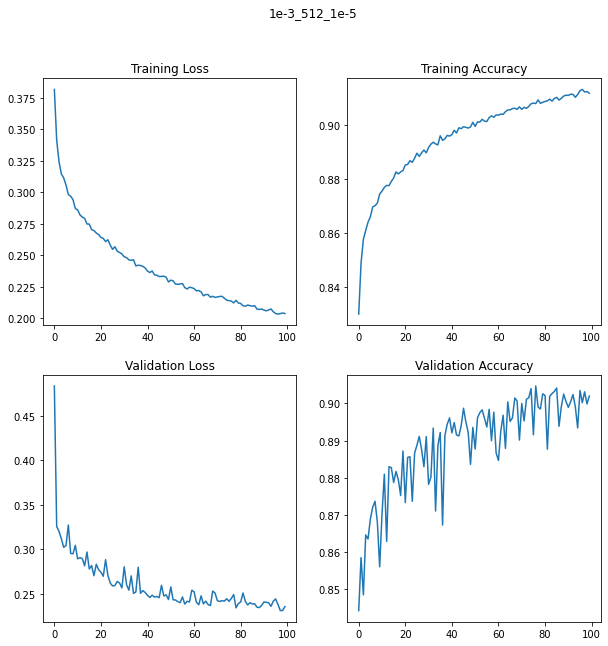

Training set: 
114456/125000
Test set: 
66138/73120


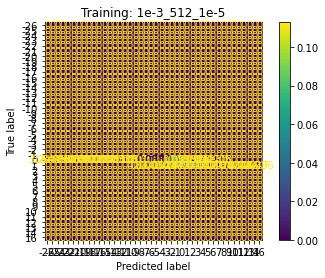

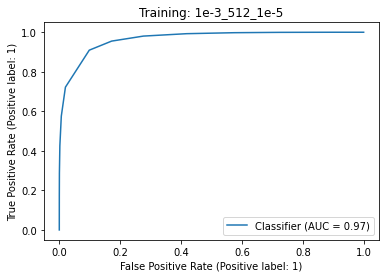

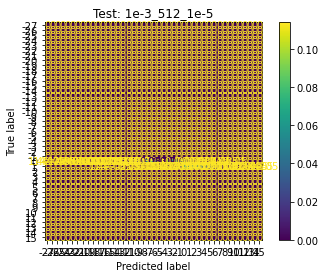

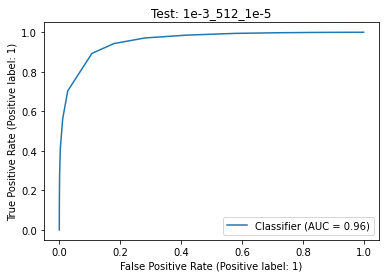

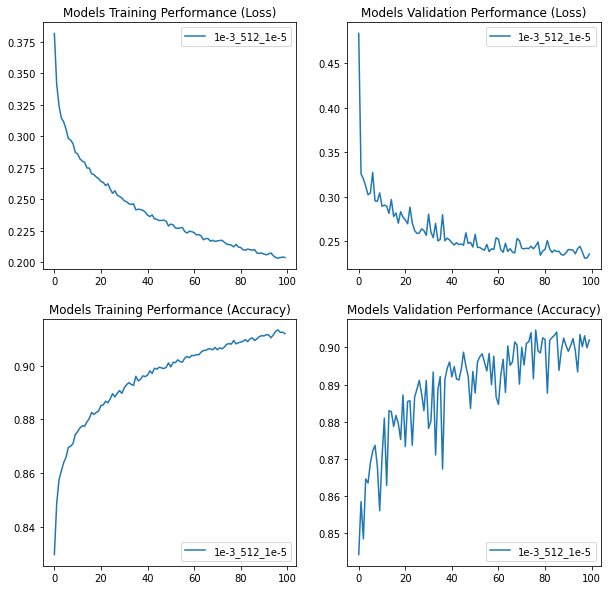

In [ ]:
training_losses = []
val_losses = []

training_acc = []
val_acc= []

for i in range(len(models)):
  trainer = Trainer( 
      model=models[i]["model"], 
      loss_function=nn.BCEWithLogitsLoss(),
      optimizer=optim.Adam(models[i]["model"].parameters(), lr=models[i]["learning_rate"], weight_decay = 1e-5), 
      num_epochs=100, 
      train_loader=DataLoader(train_set, models[i]["batch_size"], shuffle=True, num_workers=8), 
      test_loader=DataLoader(test_set, models[i]["batch_size"], shuffle=True, num_workers=8), 
      val_loader=DataLoader(val_set, models[i]["batch_size"], shuffle=True, num_workers=8))
  results = trainer.training()
  torch.save(models[i]["model"], f"/content/drive/MyDrive/data/{models[i]['model'].name}.pt")
  training_losses.append(results['train_loss'])
  val_losses.append(results['val_loss'])
  training_acc.append(results['train_acc'])
  val_acc.append(results['val_acc'])
  
def plot_models_losses(): 
  fig, axs = plt.subplots(2,2, figsize=(10,10))

  for i in range(len(models)): 
    axs[0,0].plot(training_losses[i], label=models[i]["model"].name)
    axs[0,0].set_title("Models Training Performance (Loss)")
    axs[0,0].legend(loc="upper right")

    axs[0,1].plot(val_losses[i], label=models[i]["model"].name)
    axs[0,1].set_title("Models Validation Performance (Loss)")
    axs[0,1].legend(loc="upper right")

    axs[1,0].plot(training_acc[i],label=models[i]["model"].name)
    axs[1,0].set_title("Models Training Performance (Accuracy)")
    axs[1,0].legend(loc="lower right")

    axs[1,1].plot(val_acc[i], label=models[i]["model"].name)
    axs[1,1].set_title("Models Validation Performance (Accuracy)")
    axs[1,1].legend(loc="lower right")

  plt.show() 

plot_models_losses()

In [ ]:
model = torch.load("drive/MyDrive/data/1e-3_512_1e-5.pt")
print(model.state_dict())

OrderedDict([('conv1.weight', tensor([[[[ 1.5811e-01, -6.3285e-02,  4.4916e-02],
          [ 5.1037e-02,  1.2287e-01, -2.2381e-02],
          [ 2.2311e-01,  2.1255e-01,  9.5968e-02]],

         [[ 3.7218e-02,  8.9253e-02,  1.2523e-01],
          [-1.5733e-02, -1.2945e-01, -4.8299e-02],
          [ 2.2552e-01,  1.8991e-01,  4.5201e-02]],

         [[ 8.3866e-02,  5.6294e-02,  2.7236e-02],
          [-1.3100e-01, -4.6068e-02,  1.5638e-01],
          [ 1.6004e-01,  1.9642e-01, -1.1051e-01]]],


        [[[-8.9368e-02,  1.0737e-01,  3.5026e-02],
          [ 3.3342e-01,  3.7426e-02,  7.5125e-02],
          [ 9.3443e-02,  2.4519e-02, -1.0255e-02]],

         [[ 6.2891e-02, -8.1919e-02, -9.8486e-02],
          [-2.3363e-01,  5.5232e-02, -1.7776e-01],
          [-4.1062e-02, -1.8081e-01,  7.9398e-02]],

         [[ 1.6118e-01,  7.1423e-02,  1.8362e-01],
          [-8.5414e-02, -7.3914e-02,  1.7528e-01],
          [-2.4792e-03,  2.3373e-01, -9.5166e-02]]],


        [[[ 1.3216e-01,  1.1577e-01,

In [ ]:
# append patient 10299 onto dataframe 
benign = "10299/0/"
malignant = "10299/1/"
patient_data = []
for filename in os.listdir(benign): 
  img = io.imread(benign + "/" + filename)
  id = filename.split("_")[0]

  x_cor = filename.split("_")[2][1:]
  y_cor = filename.split("_")[3][1:]
  
  if(np.array_equal(img.shape, np.array([50,50,3]))): 
    patient_data.append({ 
        "ID": int(id),
        "cancer": 0, 
        "path": benign + "/" + filename,
        "x_cor": int(x_cor),
        "y_cor": int(y_cor)
    })
for filename in os.listdir(malignant): 
  img = io.imread(malignant + "/" + filename)
  id = filename.split("_")[0]

  x_cor = filename.split("_")[2][1:]
  y_cor = filename.split("_")[3][1:]
  if(np.array_equal(img.shape, np.array([50,50,3]))): 
    patient_data.append({ 
        "ID": int(id),
        "cancer": 1, 
        "path": malignant + "/" + filename,
        "x_cor": int(x_cor),
        "y_cor": int(y_cor)
    })
patient_df = pd.DataFrame(patient_data)
print(patient_df)
patient_df.to_csv("patient.csv")

         ID  cancer                                        path  x_cor  y_cor
0     10299       0    10299/0//10299_idx5_x301_y551_class0.png    301    551
1     10299       0   10299/0//10299_idx5_x651_y2551_class0.png    651   2551
2     10299       0  10299/0//10299_idx5_x2101_y2251_class0.png   2101   2251
3     10299       0    10299/0//10299_idx5_x901_y101_class0.png    901    101
4     10299       0   10299/0//10299_idx5_x1001_y151_class0.png   1001    151
...     ...     ...                                         ...    ...    ...
2097  10299       1  10299/1//10299_idx5_x2051_y1201_class1.png   2051   1201
2098  10299       1  10299/1//10299_idx5_x1401_y1451_class1.png   1401   1451
2099  10299       1   10299/1//10299_idx5_x2101_y851_class1.png   2101    851
2100  10299       1   10299/1//10299_idx5_x1001_y501_class1.png   1001    501
2101  10299       1  10299/1//10299_idx5_x1751_y2201_class1.png   1751   2201

[2102 rows x 5 columns]


In [ ]:
patient_dataset = BreastCancerIDC(csv_file="patient.csv", transform=transforms.Compose([
   transforms.ToTensor(), 
   transforms.Normalize((0.7183, 0.5589, 0.6473), (0.2765, 0.2514, 0.2582)),
   transforms.RandomRotation(degrees=90),
   transforms.RandomHorizontalFlip(),
   transforms.RandomVerticalFlip(),
]))
loader = DataLoader(patient_dataset, 512, shuffle=False, num_workers=8)

samples = 0
correct = 0

predictions = []
with torch.no_grad():
  for batch_idx, (x, y) in enumerate(tqdm(loader)): 
      scores = model(x.to(device).float())
      results = (scores > 0.5)
      predictions.append(scores > 0.5) 
      correct += (results == y.to(device).float()).sum()
      samples += scores.size(0)

flat_list = [item for sublist in predictions for item in sublist]
print(len(flat_list))
print(correct / samples * 100)

100%|██████████| 5/5 [00:07<00:00,  1.54s/it]

2102
tensor(84.2531, device='cuda:0')


In [ ]:
data_predicted = []
for i in tqdm(range(len(flat_list))): 
    data_predicted.append({ 
      "ID": int(patient_dataset.observations.iloc[i]["ID"]),
      "cancer": int(flat_list[i]), 
      "path": patient_dataset.observations.iloc[i]["path"],
      "x_cor": int(patient_dataset.observations.iloc[i]["x_cor"]),
      "y_cor": int(patient_dataset.observations.iloc[i]["y_cor"])
    })

df_predictions = pd.DataFrame(data_predicted)
print(df_predictions)


100%|██████████| 2102/2102 [00:00<00:00, 2248.93it/s]

         ID  cancer                                        path  x_cor  y_cor
0     10299       0    10299/0//10299_idx5_x301_y551_class0.png    301    551
1     10299       0   10299/0//10299_idx5_x651_y2551_class0.png    651   2551
2     10299       0  10299/0//10299_idx5_x2101_y2251_class0.png   2101   2251
3     10299       0    10299/0//10299_idx5_x901_y101_class0.png    901    101
4     10299       0   10299/0//10299_idx5_x1001_y151_class0.png   1001    151
...     ...     ...                                         ...    ...    ...
2097  10299       1  10299/1//10299_idx5_x2051_y1201_class1.png   2051   1201
2098  10299       0  10299/1//10299_idx5_x1401_y1451_class1.png   1401   1451
2099  10299       1   10299/1//10299_idx5_x2101_y851_class1.png   2101    851
2100  10299       1   10299/1//10299_idx5_x1001_y501_class1.png   1001    501
2101  10299       0  10299/1//10299_idx5_x1751_y2201_class1.png   1751   2201

[2102 rows x 5 columns]


In [ ]:
random = pd.concat([df_predictions, df]).drop_duplicates(keep=False)

print(random.shape[0])

275222


In [ ]:
print(df_predictions.head(1200))
print(df.head(100))

         ID  cancer                                        path  x_cor  y_cor
0     10299       0    10299/0//10299_idx5_x301_y551_class0.png    301    551
1     10299       0   10299/0//10299_idx5_x651_y2551_class0.png    651   2551
2     10299       0  10299/0//10299_idx5_x2101_y2251_class0.png   2101   2251
3     10299       0    10299/0//10299_idx5_x901_y101_class0.png    901    101
4     10299       0   10299/0//10299_idx5_x1001_y151_class0.png   1001    151
...     ...     ...                                         ...    ...    ...
1195  10299       1   10299/1//10299_idx5_x2101_y551_class1.png   2101    551
1196  10299       0   10299/1//10299_idx5_x851_y1201_class1.png    851   1201
1197  10299       1   10299/1//10299_idx5_x1701_y851_class1.png   1701    851
1198  10299       0  10299/1//10299_idx5_x2001_y2051_class1.png   2001   2051
1199  10299       0   10299/1//10299_idx5_x551_y2001_class1.png    551   2001

[1200 rows x 5 columns]
       ID  cancer                      

In [ ]:
df_predictions.to_csv("predictions.csv")

In [ ]:
print(patient_df)

         ID  cancer                                        path  x_cor  y_cor
0     10299       0    10299/0//10299_idx5_x301_y551_class0.png    301    551
1     10299       0   10299/0//10299_idx5_x651_y2551_class0.png    651   2551
2     10299       0  10299/0//10299_idx5_x2101_y2251_class0.png   2101   2251
3     10299       0    10299/0//10299_idx5_x901_y101_class0.png    901    101
4     10299       0   10299/0//10299_idx5_x1001_y151_class0.png   1001    151
...     ...     ...                                         ...    ...    ...
2097  10299       1  10299/1//10299_idx5_x2051_y1201_class1.png   2051   1201
2098  10299       1  10299/1//10299_idx5_x1401_y1451_class1.png   1401   1451
2099  10299       1   10299/1//10299_idx5_x2101_y851_class1.png   2101    851
2100  10299       1   10299/1//10299_idx5_x1001_y501_class1.png   1001    501
2101  10299       1  10299/1//10299_idx5_x1751_y2201_class1.png   1751   2201

[2102 rows x 5 columns]


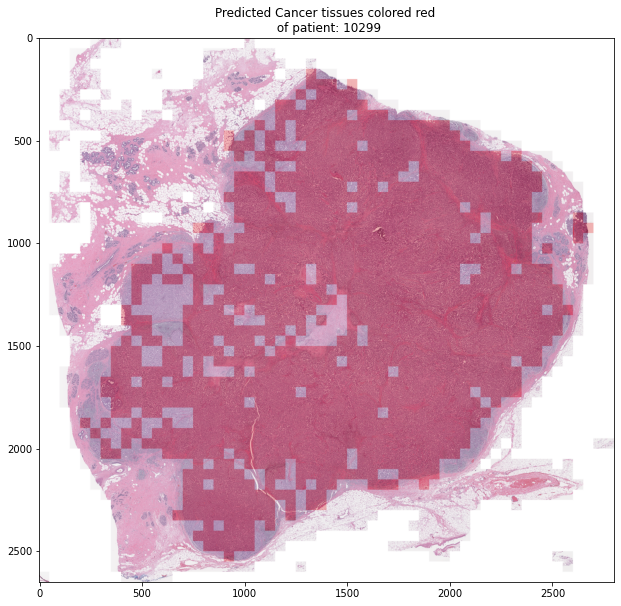

In [ ]:
patient_id = 10299
grid_pred, mask_pred, broken_patches,_ = visualise_breast_tissue(patient_id, df_predictions)
grid_real, mask_real, _, _ = visualise_breast_tissue(patient_id, patient_df)

fig = plt.figure(figsize=(20,10))
plt.imshow(mask_pred, alpha=0.8)
plt.imshow(grid_pred, alpha=0.7)
plt.grid(False)
plt.title("Predicted Cancer tissues colored red \n of patient: " + str(patient_id))
plt.show()


# fig, ax = plt.subplots(1,1, figsize=(20,10))
# ax[0].imshow(grid_real, alpha=0.9)

# ax[1].imshow(mask_real, alpha=0.8)
# ax[1].imshow(grid_real, alpha=0.7)

# ax[2].imshow(mask_pred, alpha=0.8)
# ax[2].imshow(grid_pred, alpha=0.7)

# ax[0].grid(False)
# ax[1].grid(False)
# ax[2].grid(False)

# for m in range(0, 1):
#     ax[m].set_xlabel("y-coord")
#     ax[m].set_ylabel("x-coord")
# ax[0].set_title("Breast tissue slice of patient: " + str(patient_id))
# ax[1].set_title("Cancer tissue colored red \n of patient: " + str(patient_id))
# ax[2].set_title("Predicted Cancer tissues colored red \n of patient: " + str(patient_id))
